In [1]:
from Bio import SeqIO
from Bio.Seq import Seq
import os
import numpy as np
from mutedpy.experiments.od1.loader import get_wiltype_seq

def load_sequences(filepath):
    """Load all sequences from a FASTA file."""
    with open(filepath, "r") as file:
        return [record.seq for record in SeqIO.parse(file, "fasta")]

def compare_sequences(wildtype, mutant):
    """Compare two sequences and return a list of mutated positions."""
    return [i for i, (wt, mt) in enumerate(zip(wildtype, mutant)) if wt != mt]

def convert_dna_to_protein(dna):
    my_seq = Seq(dna)
    prot_seq = str(my_seq.translate())
    prot_seq = prot_seq[0:-1]
    prot_seq = prot_seq.replace('*', '<mask>')
    return prot_seq

def convert_to_protein(seqs):
    r = []
    for s in seqs:
        r.append(convert_dna_to_protein(s))
    return r

def get_percentages(sequences,wt_seq, dna = True, unique = False, normalized = True):
    counts = np.zeros(len(wt_seq))
    wt_arr = np.array(list(wt_seq))
    total_count = 0
    # Perform element-wise comparison and convert boolean results to integers (1s and 0s)

    if unique: 
        # remove duplicates 
        print ("No seq:",len(sequences))
        sequences = list(set(sequences))
        print ("No unique seqs:", len(sequences))
    else:
        print ("No seqs:", len(sequences))
        pass
    
    for dna_seq in sequences:
        if dna:
            seq = convert_dna_to_protein(dna_seq)
        else:
            seq = dna_seq
        arr = np.array(list(seq))
        
        if len(arr)==97:
            comparison_array = (arr != wt_arr).astype(int)
            counts += comparison_array
            total_count += 1
            
    # Calculate the percentages
    if normalized:
        percentages = 100 * counts / total_count
    else:
        percentages = counts
    return percentages

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
max_sort = 9
unique = False
sorts_evo_1 = [2,3,4]
sorts_evo_2 = [6,7,8]

In [6]:
# load wiltype 

y_vals = []
seqs = []

sort_1_values = [1,1.2,3]
sort_2_values = [4.,5.,6.]

print ("Evo1")
for index, i in enumerate(sorts_evo_1):
    sequences = convert_to_protein(load_sequences("../filtered_data/"+str(i)+".fasta"))
    print ("sort:"+str(index+1), len(sequences), "unique:", len(set(sequences)))
    seqs = seqs + sequences
    y_vals = y_vals + [sort_1_values[index]]*len(sequences) 

y_vals2 = []
seqs2 = []
print ("Evo2")
for index, i in enumerate(sorts_evo_2):
    sequences = convert_to_protein(load_sequences("../filtered_data/"+str(i)+".fasta"))
    print ("sort:"+str(index+1), len(sequences), "unique:", len(set(sequences)))
    seqs2 = seqs2 + sequences
    y_vals2 = y_vals2 + [sort_2_values[index]]*len(sequences) 

    #percentages = get_percentages(sequences,wt_seq)
    #results_unique.append(get_percentages(sequences,wt_seq, unique = True))
    #results.append(percentages)
    #y_vals = 

evolution = [1]*len(seqs) + [2]*len(seqs2)


Evo1
sort:1 550022 unique: 5255
sort:2 431682 unique: 4599
sort:3 796109 unique: 8586
Evo2
sort:1 683128 unique: 32211
sort:2 803558 unique: 33175
sort:3 681683 unique: 18750


In [8]:
dts = pd.DataFrame({'seq':seqs+ seqs2,'val':y_vals+y_vals2,'evo':evolution}) 

In [9]:
if unique:
    dts = dts.drop_duplicates()
else:
    pass 

In [10]:
evolution_1_data = dts[dts['evo']==1]
evolution_2_data = dts[dts['evo']==2]

In [11]:
from mutedpy.experiments.od1.loader import filter_seq, load_data_pickle
import torch 

In [12]:
#filter_seq(evolution_1_data['seq'],y)
y1 = evolution_1_data['val']>=1.
y2 = evolution_1_data['val']>=1.2
y3 = evolution_1_data['val']>=3.
seq = evolution_1_data['seq']
y = np.concatenate([y1.values.reshape(-1,1),y2.values.reshape(-1,1),y3.values.reshape(-1,1)], axis = 1)


#filter_seq(evolution_1_data['seq'],y)
y1 = evolution_2_data['val']>=4.
y2 = evolution_2_data['val']>=5
y3 = evolution_2_data['val']>=6.
seq2 = evolution_2_data['seq']
y2 = np.concatenate([y1.values.reshape(-1,1),y2.values.reshape(-1,1),y3.values.reshape(-1,1)], axis = 1)

In [13]:
seq

0          GSGSPLAQQIKNTLTFIGQANAAGRMDEVRTLQQNLHPLWAEYFQQ...
1          GSGSPLAQQIKNTLTFIGQANAAGRMDEVRTLQQNLHPLWAEYFQQ...
2          GSGSPLAQQIKNTLTFIGQANAAGRMDEVRTLQQNLHPLWAEYFQQ...
3          GSGSPLAQQIKNTLTFIGQANAAGRMDEVRTLQQNLHPLWAEYFQQ...
4          GSGSPLAQQIKNTLTFIGQANAAGRMDEVRTLQQNLHPLWAEYFQQ...
                                 ...                        
1777808    GSGSPLAQQIKNTLTFIGQANAAGRMDEVRTLQRNLHPLWAEYFQQ...
1777809    GSGSPLAQQIKNTLTFIGQANAAGRMDEVRTLQQNLHPLWAEYFQQ...
1777810    GSGSPLAKQIKNTLTFIGQANAAGRMDEVRTLQQNLHPLWAEYFQQ...
1777811    GSGSPLAQQIKNTLTFIGQANAAGRMDEVRTLQKNLHPLWAEYFQQ...
1777812    GSGSPLAQQIKNTLTFIGQANAAGRMDEVRTLQKNLHPLWAEYFRL...
Name: seq, Length: 1777813, dtype: object

In [14]:
new_seq = []
new_y = []
no_sorts = 3
new_seqs = pd.DataFrame(seq.values, columns=['variant'])
for i in range(3):
    new_seqs[str(i)] = y[:, i]
new_seqs['occ'] = 1.

agg_dict = {}
agg_list = [{str(i) : 'sum'} for i in range(no_sorts)] + [{'occ':'sum'}]
for d in agg_list:
    agg_dict.update(d)

#if unique:
new_seqs = new_seqs.groupby('variant').agg(agg_dict).reset_index()
#else:
#new_seqs.agg(agg_dict).reset_index()

In [15]:
def is_sorted_descending(lst):
    return all(lst[i] > lst[i + 1] or (lst[i+1]==0 and lst[i]==0) for i in range(len(lst) - 1))

for index, row in new_seqs.iterrows():

    if is_sorted_descending([row[str(i)] for i in range(no_sorts)]):
       # print ("good.", row)

        yn = torch.zeros(size=(1, no_sorts)).bool()
        new_seq.append(row['variant'])
        ac = max([i if row[str(i)]>0 else 0 for i in range(no_sorts)])
        yn[0,0:ac+1] = 1.
        new_y.append(yn)
#
# # unique sequences
# unique_seqs = list(set(new_seqs.values.tolist()))
#
# for index, seq in enumerate(unique_seqs):
#     print (index, len(unique_seqs))
#     mask = new_seqs == seq
#     entries = y[mask, :]
#
#     occurences = entries.size()[0]
#     #print (entries)
#     #print (entries.sum(dim = 0))
#     sums = entries.sum(dim = 0)
#     if all([sums[i] == max(0,occurences-i) for i in range(no_sorts)]):
#         # print ('------------------')
#         # print("true entry.")
#         # print('------------------')
#         for i in range(occurences):
#             new_seq.append(seq)
#         new_y.append(entries)
#

new_y = torch.vstack(new_y)
print ("Filtering finished:")
for i in range(3):
    print (torch.sum(new_y[:, i]))

Filtering finished:
tensor(4922)
tensor(918)
tensor(599)


In [16]:
row['occ']

1.0

In [17]:
seq, y = filter_seq(seq,torch.from_numpy(y))
seq2, y2 = filter_seq(seq2,torch.from_numpy(y2), no_mutants = 10)

Filtering start
1777813
length filter.
1746410
mask filter.
1746410
no_mutatations filter.
1741169
sorting filter.
Filtering finished:
tensor(4056)
tensor(842)
tensor(551)
filtering done
4056
Filtering start
2168369
length filter.
2046717
mask filter.
2046717
no_mutatations filter.
2046624
sorting filter.
Filtering finished:
tensor(26215)
tensor(7672)
tensor(2120)
filtering done
26215


In [18]:
wt_seq = get_wiltype_seq()
print (len(wt_seq))
# iterate on sorts 

97


In [19]:
results = []
for index, sort in enumerate([0,1,2]):
    mask = y[:,sort]
    sequences = [seq[i] for i,e in enumerate(mask) if e]
    percentages = get_percentages(sequences,wt_seq, dna = False, unique = False, normalized = True)
    results.append(percentages)
for index, sort in enumerate([0,1,2]):
    mask = y2[:,sort]
    sequences = [seq2[i] for i,e in enumerate(mask) if e]
    percentages = get_percentages(sequences,wt_seq, dna = False, unique = False, normalized = True)
    results.append(percentages)

No seqs: 4056
No seqs: 842
No seqs: 551
No seqs: 26215
No seqs: 7672
No seqs: 2120


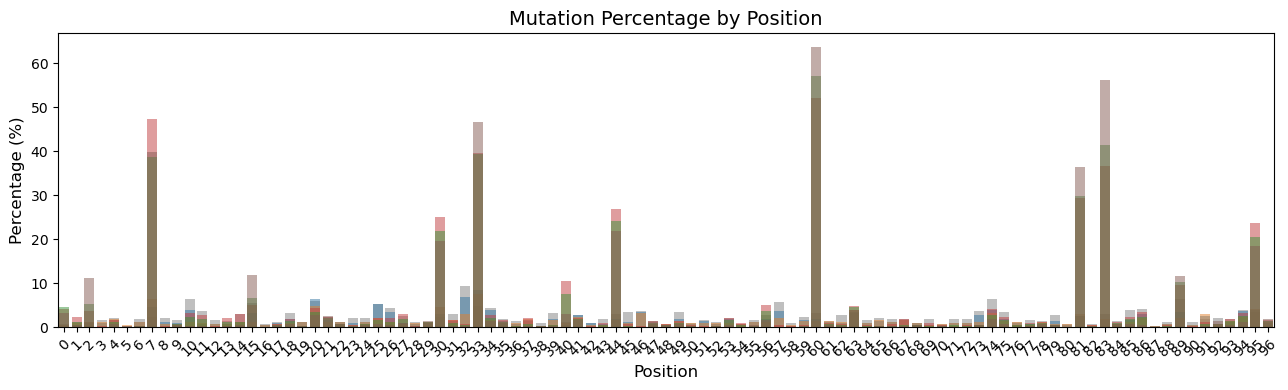

In [20]:
import seaborn as sns 
# Calculate the percentages
colors = ['gray','tab:blue','tab:orange','tab:red','tab:green',"tab:brown"]
names = ['Evolution 1 - Sort1','Evolution 1 - Sort2','Evolution 1 - Sort3','Evolution 2 - Sort1','Evolution 2 - Sort2','Evolution 2 - Sort3']
plt.figure(figsize=(13, 4))  # Adjust the figsize to control the aspect ratio, making it wider

for index,j in enumerate(results):
    percentages = j
    
    # Create a DataFrame for easier plotting with Seaborn
    import pandas as pd
    data = pd.DataFrame({'Position': np.arange(0,len(wt_seq),1), 'Percentage': percentages})
    
    # Plotting
    sns.barplot(x='Position', y='Percentage', data=data, color=colors[index], label = names[index], alpha = 0.5)  # Use Seaborn's barplot

# Enhancements
plt.title('Mutation Percentage by Position', fontsize=14)
plt.xlabel('Position', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()  # Adjust layout to not cut off labels
plt.savefig("second-sequencing-hit-analysis-unique.png",dpi=200)
plt.show()

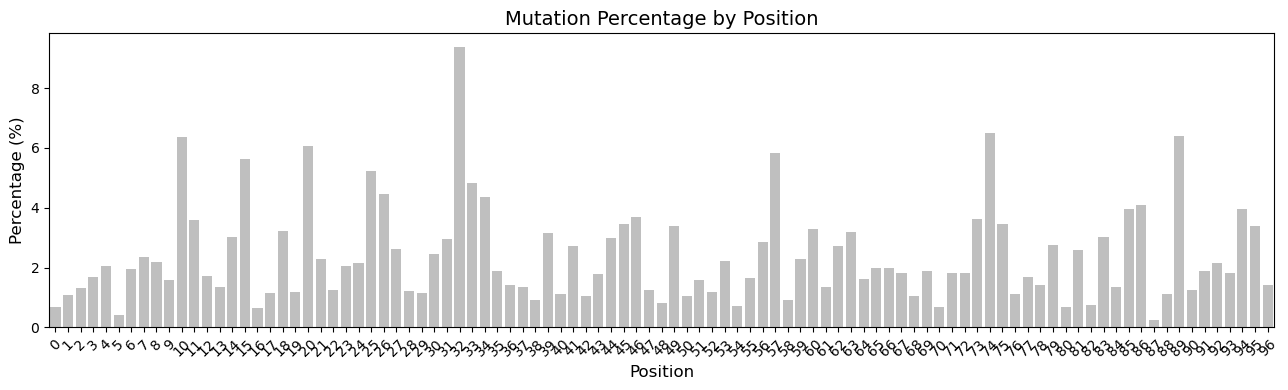

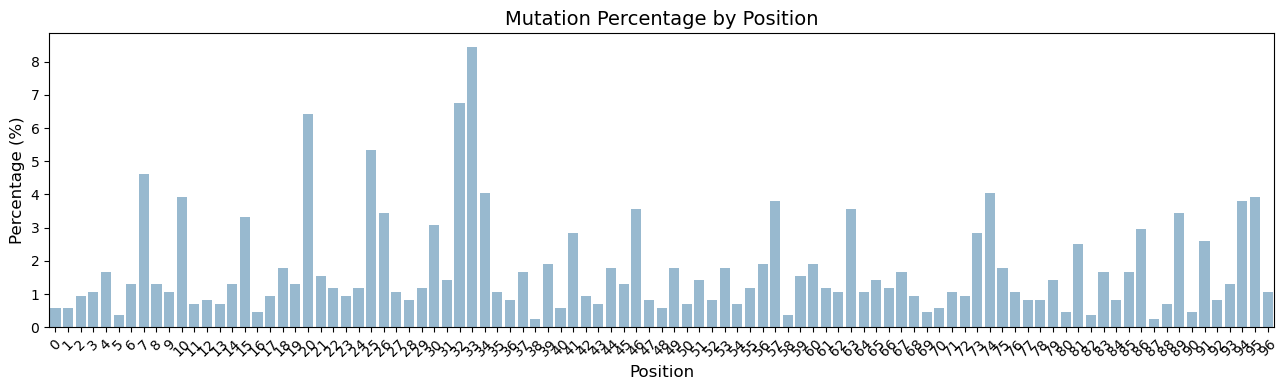

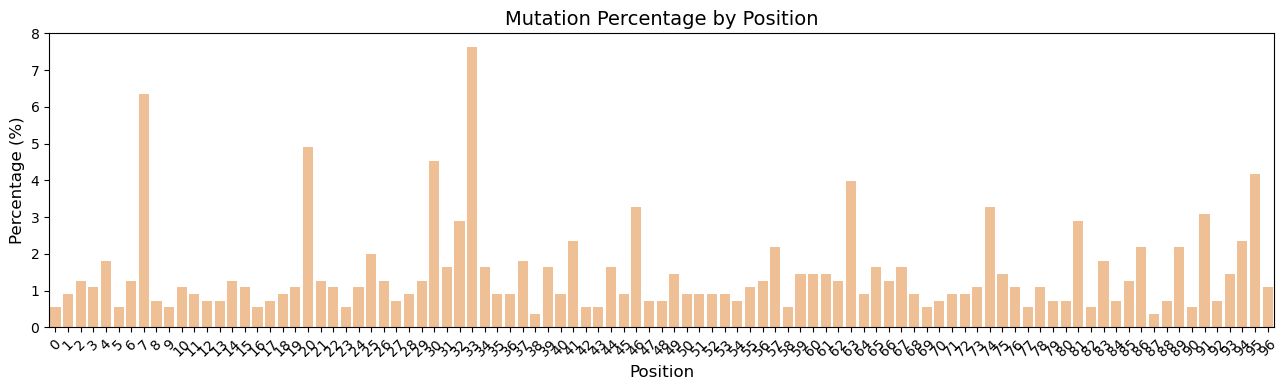

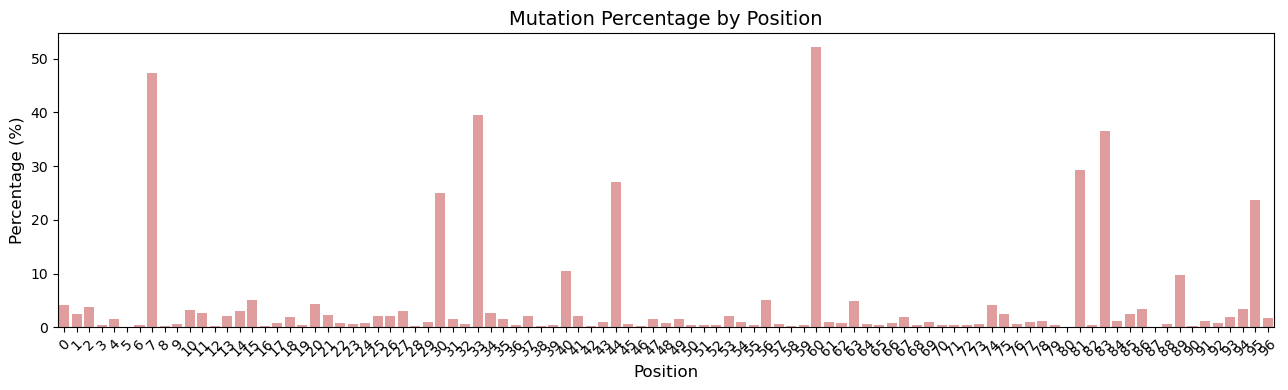

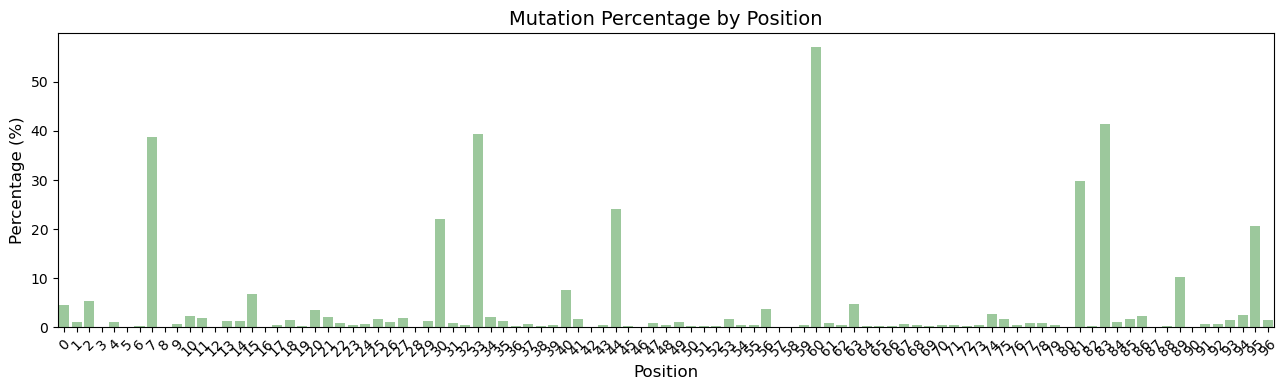

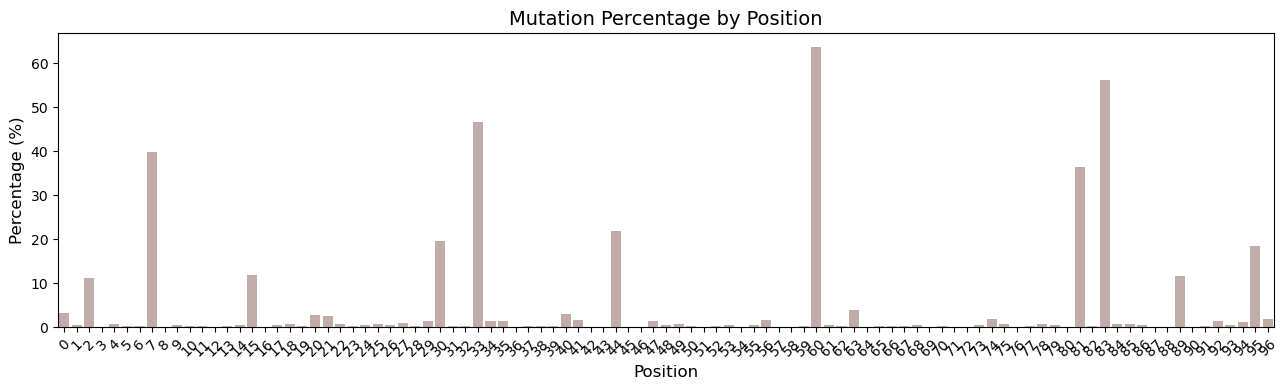

In [21]:
# Create a DataFrame for easier plotting with Seaborn

for index,j in enumerate(results):
    percentages = j
    plt.figure(figsize=(13, 4))  # Adjust the figsize to control the aspect ratio, making it wider
    data = pd.DataFrame({'Position': np.arange(0,len(wt_seq),1), 'Percentage': percentages})
        
    # Plotting
    sns.barplot(x='Position', y='Percentage', data=data, color=colors[index], label = names[index], alpha = 0.5)  # Use Seaborn's barplot
    
    # Enhancements
    plt.title('Mutation Percentage by Position', fontsize=14)
    plt.xlabel('Position', fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.tight_layout()  # Adjust layout to not cut off labels
    plt.savefig("hit_plots/hit_analysis_"+names[index]+"-unique.png",dpi=200)
    #plt.show()

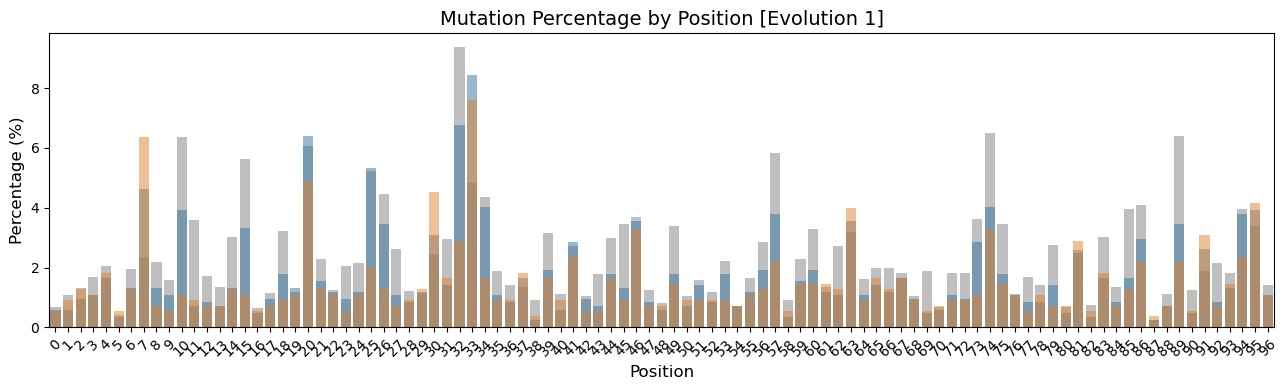

In [22]:
# Create a DataFrame for easier plotting with Seaborn
plt.figure(figsize=(13, 4))  # Adjust the figsize to control the aspect ratio, making it wider
for index in range(0,3,1):
    percentages = results[index]
    data = pd.DataFrame({'Position': np.arange(0,len(wt_seq),1), 'Percentage': percentages})
        
    # Plotting
    sns.barplot(x='Position', y='Percentage', data=data, color=colors[index], label = names[index], alpha = 0.5)  # Use Seaborn's barplot
    
    # Enhancements
plt.title('Mutation Percentage by Position [Evolution 1]', fontsize=14)
plt.xlabel('Position', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()  # Adjust layout to not cut off labels
plt.savefig("hit_plots/hit_analysis_evolution-1-unique.png",dpi=200)
    #plt.show()

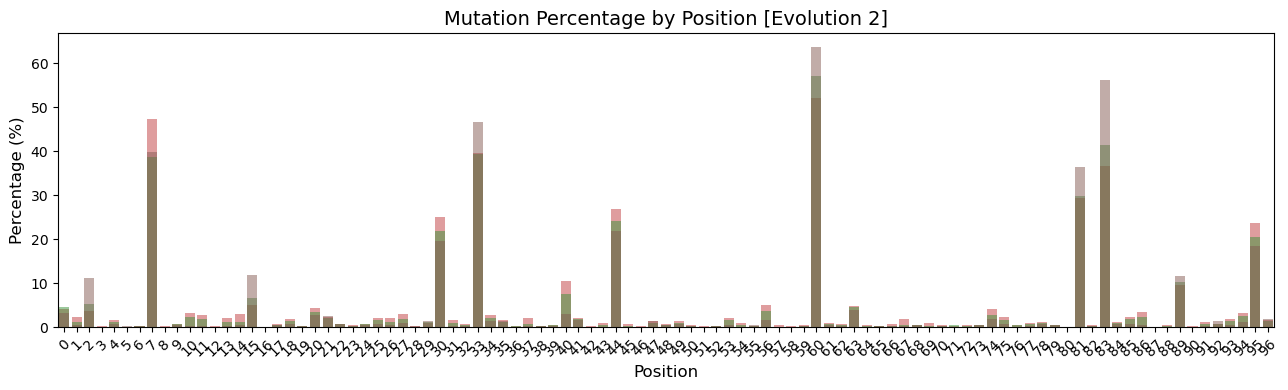

In [23]:
# Create a DataFrame for easier plotting with Seaborn
plt.figure(figsize=(13, 4))  # Adjust the figsize to control the aspect ratio, making it wider
for index in range(3,6,1):
    percentages = results[index]
    data = pd.DataFrame({'Position': np.arange(0,len(wt_seq),1), 'Percentage': percentages})
        
    # Plotting
    sns.barplot(x='Position', y='Percentage', data=data, color=colors[index], label = names[index], alpha = 0.5)  # Use Seaborn's barplot
    
    # Enhancements
plt.title('Mutation Percentage by Position [Evolution 2]', fontsize=14)
plt.xlabel('Position', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()  # Adjust layout to not cut off labels
plt.savefig("hit_plots/hit_analysis_evolution-2-unique.png",dpi=200)
    #plt.show()

In [24]:
results = []
unique = True
normalized = True
for index, sort in enumerate([1.,1.2,3.]):
    sequences = evolution_1_data[evolution_1_data['val']==sort]['seq']
    print (len(sequences))
    percentages = get_percentages(sequences,wt_seq, dna = False, unique = unique, normalized = normalized)
    results.append(percentages)

for index, sort in enumerate([4.,5.,6.]):
    sequences = evolution_2_data[evolution_2_data['val']==sort]['seq']
    print (len(sequences))
    percentages = get_percentages(sequences,wt_seq, dna = False,unique = unique, normalized = normalized)
    results.append(percentages)

550022
No seq: 550022
No unique seqs: 5255
431682
No seq: 431682
No unique seqs: 4599
796109
No seq: 796109
No unique seqs: 8586
683128
No seq: 683128
No unique seqs: 32211
803558
No seq: 803558
No unique seqs: 33175
681683
No seq: 681683
No unique seqs: 18750


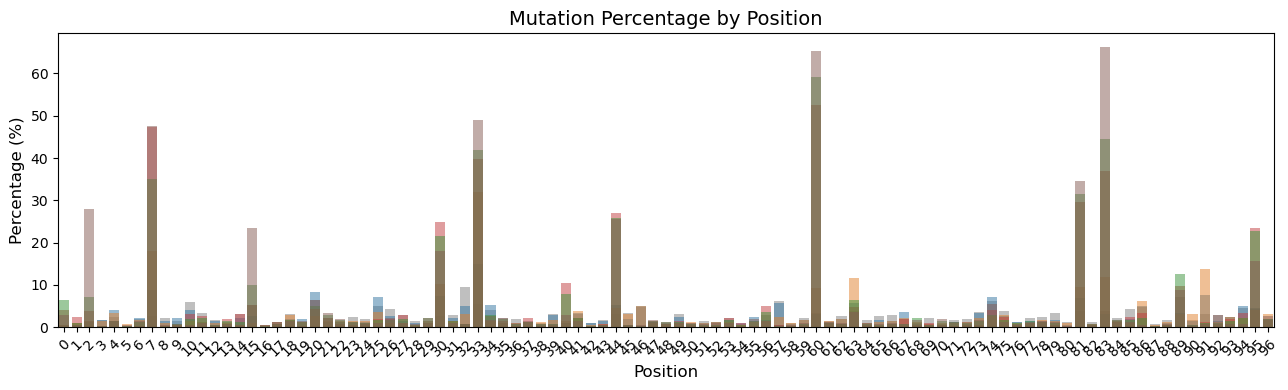

In [25]:
import seaborn as sns 
# Calculate the percentages
colors = ['gray','tab:blue','tab:orange','tab:red','tab:green',"tab:brown"]
names = ['Evolution 1 - Sort1','Evolution 1 - Sort2','Evolution 1 - Sort3','Evolution 2 - Sort1','Evolution 2 - Sort2','Evolution 2 - Sort3']
plt.figure(figsize=(13, 4))  # Adjust the figsize to control the aspect ratio, making it wider

for index,j in enumerate(results):
    percentages = j
    
    # Create a DataFrame for easier plotting with Seaborn
    import pandas as pd
    data = pd.DataFrame({'Position': np.arange(0,len(wt_seq),1), 'Percentage': percentages})
    
    # Plotting
    sns.barplot(x='Position', y='Percentage', data=data, color=colors[index], label = names[index], alpha = 0.5)  # Use Seaborn's barplot

# Enhancements
plt.title('Mutation Percentage by Position', fontsize=14)
plt.xlabel('Position', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()  # Adjust layout to not cut off labels
if unique:
    plt.savefig("second-data-set-hit-analysis-unique.png",dpi=200)
else:
    plt.savefig("second-data-set-hit-analysis.png",dpi=200)
plt.show()

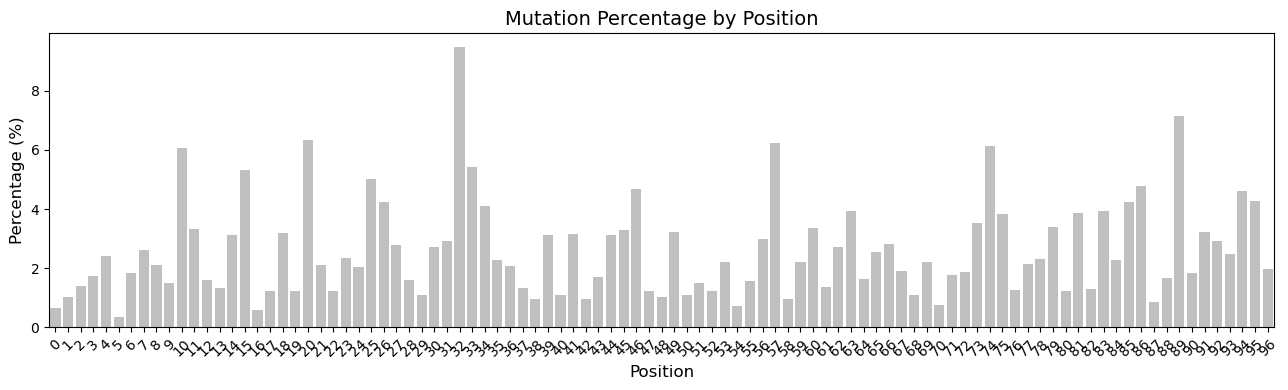

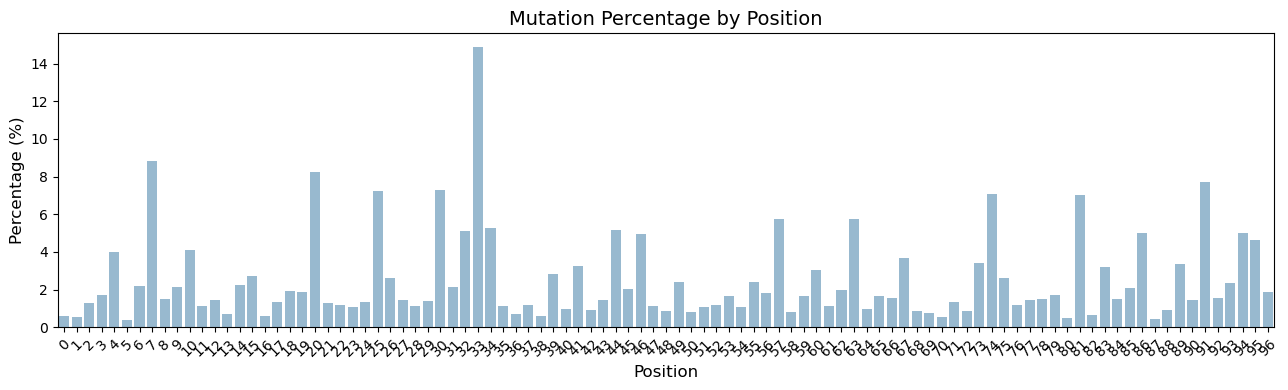

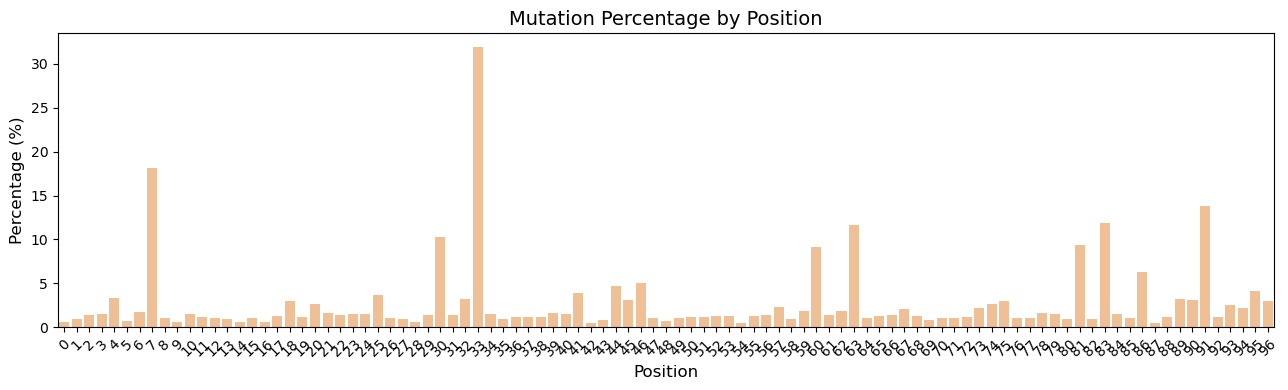

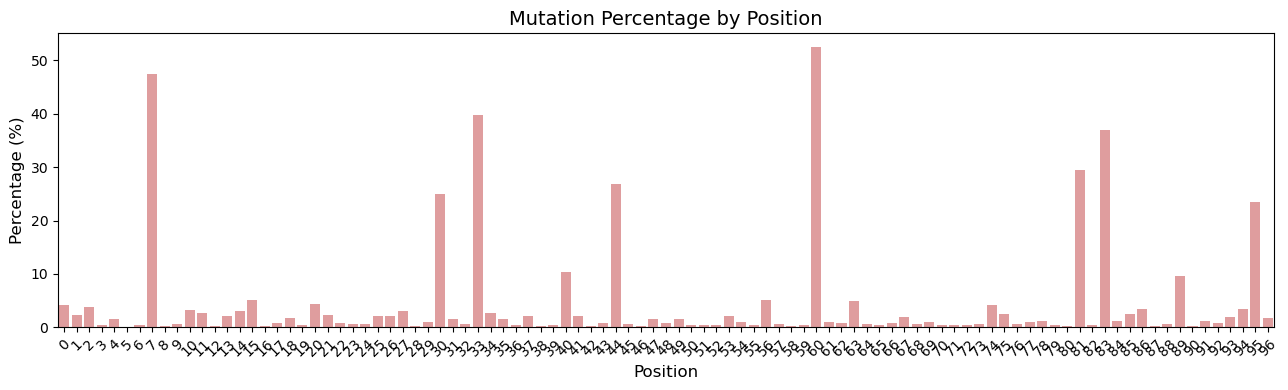

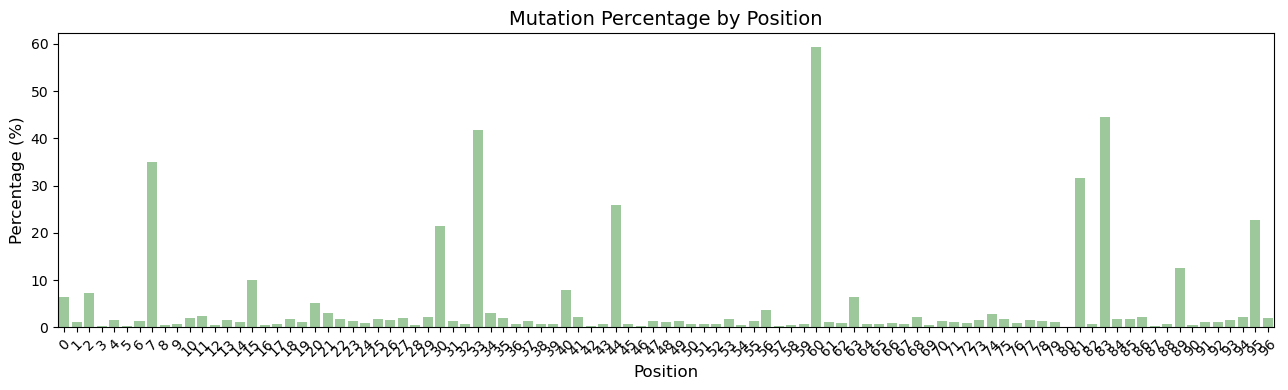

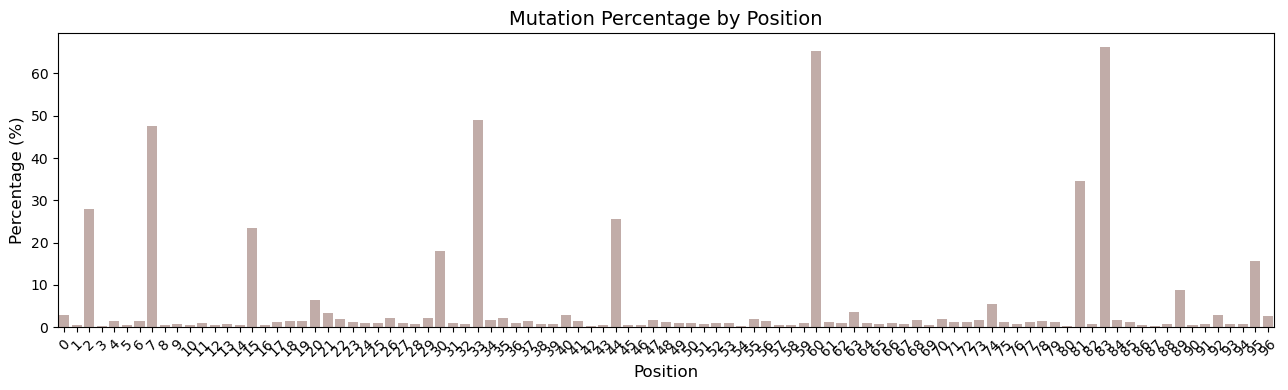

In [26]:
# Create a DataFrame for easier plotting with Seaborn

for index,j in enumerate(results):
    percentages = j
    plt.figure(figsize=(13, 4))  # Adjust the figsize to control the aspect ratio, making it wider
    data = pd.DataFrame({'Position': np.arange(0,len(wt_seq),1), 'Percentage': percentages})
        
    # Plotting
    sns.barplot(x='Position', y='Percentage', data=data, color=colors[index], label = names[index], alpha = 0.5)  # Use Seaborn's barplot
    
    # Enhancements
    plt.title('Mutation Percentage by Position', fontsize=14)
    plt.xlabel('Position', fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.tight_layout()  # Adjust layout to not cut off labels
    if unique:
        plt.savefig("hit_plots/hit_analysis_"+names[index]+"-unique.png",dpi=200)
    else:
        plt.savefig("hit_plots/hit_analysis_"+names[index]+".png",dpi=200)
    #plt.show()

In [34]:
old_results = []
seqs= []
y_vals = []
for index,sort in enumerate([2,3,4]):
    dts = pd.read_csv("../../../od1/data.csv")
    subset = dts[dts['sorting'] == sort]
    sequences = subset['variant'].values.tolist()
    print (len(set(sequences)))
    r = get_percentages(sequences,wt_seq,dna=False)
    old_results.append(r)
    seqs = seqs + sequences
    y_vals = y_vals + [sort_1_values[index]]*len(sequences) 

31302
No seqs: 64006
5858
No seqs: 12675
62652
No seqs: 177764


In [35]:
dts = pd.DataFrame({'seq':seqs,'val':y_vals,'evo':1}) 

In [41]:
y1 = dts['val']>=1.
y2 = dts['val']>=1.2
y3 = dts['val']>=3.
seq = dts['seq']
y = np.concatenate([y1.values.reshape(-1,1),y2.values.reshape(-1,1),y3.values.reshape(-1,1)], axis = 1)


In [42]:
new_seq = []
new_y = []
no_sorts = 3
new_seqs = pd.DataFrame(seq.values, columns=['variant'])
for i in range(3):
    new_seqs[str(i)] = y[:, i]
new_seqs['occ'] = 1.

agg_dict = {}
agg_list = [{str(i) : 'sum'} for i in range(no_sorts)] + [{'occ':'sum'}]
for d in agg_list:
    agg_dict.update(d)

#if unique:
new_seqs = new_seqs.groupby('variant').agg(agg_dict).reset_index()
#else:
#new_seqs.agg(agg_dict).reset_index()

In [43]:
def is_sorted_descending(lst):
    return all(lst[i] > lst[i + 1] or (lst[i+1]==0 and lst[i]==0) for i in range(len(lst) - 1))

for index, row in new_seqs.iterrows():

    if is_sorted_descending([row[str(i)] for i in range(no_sorts)]):
       # print ("good.", row)

        yn = torch.zeros(size=(1, no_sorts)).bool()
        new_seq.append(row['variant'])
        ac = max([i if row[str(i)]>0 else 0 for i in range(no_sorts)])
        yn[0,0:ac+1] = 1.
        new_y.append(yn)
#
# # unique sequences
# unique_seqs = list(set(new_seqs.values.tolist()))
#
# for index, seq in enumerate(unique_seqs):
#     print (index, len(unique_seqs))
#     mask = new_seqs == seq
#     entries = y[mask, :]
#
#     occurences = entries.size()[0]
#     #print (entries)
#     #print (entries.sum(dim = 0))
#     sums = entries.sum(dim = 0)
#     if all([sums[i] == max(0,occurences-i) for i in range(no_sorts)]):
#         # print ('------------------')
#         # print("true entry.")
#         # print('------------------')
#         for i in range(occurences):
#             new_seq.append(seq)
#         new_y.append(entries)
#

new_y = torch.vstack(new_y)
print ("Filtering finished:")
for i in range(3):
    print (torch.sum(new_y[:, i]))

Filtering finished:
tensor(25700)
tensor(2504)
tensor(1877)


In [ ]:
import seaborn as sns 
# Calculate the percentages
colors = ['gray','tab:blue','tab:orange','tab:red','tab:green',"tab:brown"]
for index,j in enumerate(old_results):
    plt.figure(figsize=(13, 4))  # Adjust the figsize to control the aspect ratio, making it wider

    percentages = j
    
    # Create a DataFrame for easier plotting with Seaborn
    import pandas as pd
    data = pd.DataFrame({'Position': np.arange(0,len(wt_seq),1), 'Percentage': percentages})
    
    # Plotting
    sns.barplot(x='Position', y='Percentage', data=data, color=colors[index], label = 'sort '+str(index+1), alpha = 0.5)  # Use Seaborn's barplot

# Enhancements
    plt.title('Mutation Percentage by Position', fontsize=14)
    plt.xlabel('Position', fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.tight_layout()  # Adjust layout to not cut off labels
    plt.savefig("hit_plots/first-data-set-hit-analysis_sort_"+str(index+1)+".png",dpi=200)
plt.show()